In [1]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
import pandas as pd
from typing import *
import numpy as np
from itertools import product
import math
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller


# Data

In [17]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
gammas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Load and preprocess
df = pd.read_csv("data/o_sales.csv", parse_dates=["date"])
df = df.set_index("date")
df = df.asfreq("MS")

df_train = df[:-3]
df_test = df[-3:]

# Use the Series, not flattened NumPy array
df_train_one_d = df_train["quantity"]
df_test_one_d = df_test["quantity"]


# List to store valid configurations
# {error, trend, seasonal, damped_trend}
# error: "add", "mul"
# trend: "add", "mul", None
# seasonal: "add", "mul", None
# damped_trend: True, False
valid_configs = [
    {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'add', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': None, 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'add', 'seasonal': 'mul', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': None, 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'add', 'damped_trend': True},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': False},
    {'error': 'mul', 'trend': 'mul', 'seasonal': 'mul', 'damped_trend': True},
]

# Use this list if your data contains zeros or negative values
additive_configs = [
    {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False},
    {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True},
]

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def plot_acf_pacf(series):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    pd.plotting.autocorrelation_plot(series, ax=ax[0])
    ax[0].set_title("Autocorrelation Function (ACF)")
    pd.plotting.lag_plot(series, lag=1, ax=ax[1])
    ax[1].set_title("Partial Autocorrelation Function (PACF)")
    plt.show()


Results of Dickey-Fuller Test:
Test Statistic                 -1.957184
p-value                         0.305656
#Lags Used                      5.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


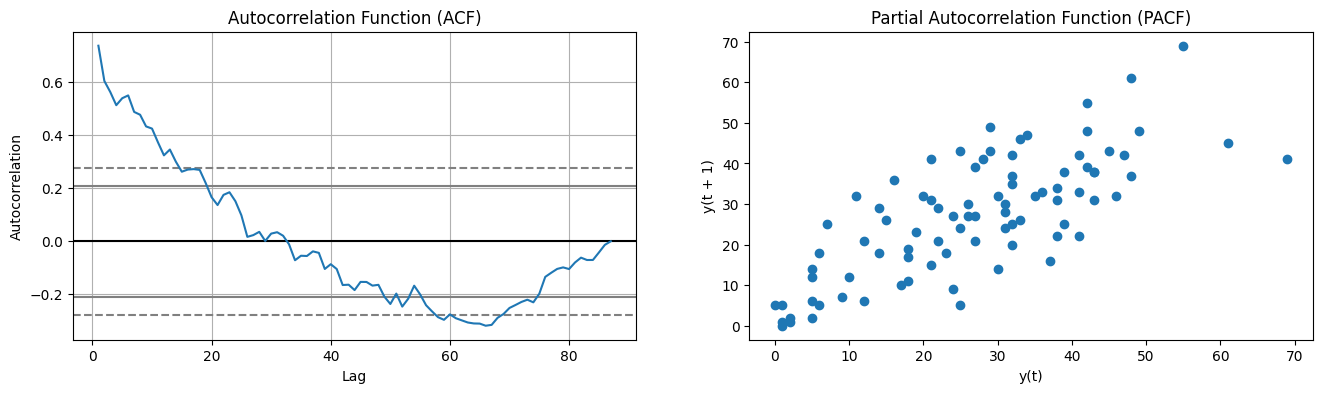

In [6]:
# Check ADF test for stationarity
adf_test(df)
# Plot ACF and PACF
plot_acf_pacf(df)

# Grid Search
Find the best model using looping and compare the MAPE, lowest MAPE is the best model.

Tuning parameters: alpha, beta, gamma using a grid search.

In [18]:
# start find best model configurations
best_mape = float("inf")
best_model = None
y_pred = None

for config in additive_configs:  # or valid_configs if you want to include multiplicative
    try:
        model = ETSModel(
            endog=df_train_one_d, 
            error=config["error"], 
            trend=config["trend"], 
            seasonal=config["seasonal"],
            damped_trend=config["damped_trend"], 
            seasonal_periods=12,
            initialization_method="estimated",
        )


        fit = model.fit(maxiter=100000)
        y_pred = fit.forecast(steps=len(df_test_one_d))
        mape = mean_absolute_percentage_error(df_test_one_d, y_pred)
        # Calculate and print MAPE
        print(f"Config: {config}, MAPE: {mape}")

        if mape < best_mape:
            best_mape = mape
            best_model = fit
        
    except Exception as e:
        print(f"Error with config {config}: {e}")


INIT HEURISTIC
Config: {'error': 'add', 'trend': None, 'seasonal': None, 'damped_trend': False}, MAPE: 0.27711635807690765
INIT HEURISTIC
Config: {'error': 'add', 'trend': None, 'seasonal': 'add', 'damped_trend': False}, MAPE: 0.22646463495525251
INIT HEURISTIC
Config: {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': False}, MAPE: 0.18889064874783978
INIT HEURISTIC
Config: {'error': 'add', 'trend': 'add', 'seasonal': None, 'damped_trend': True}, MAPE: 0.1384521659738915
INIT HEURISTIC
Config: {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': False}, MAPE: 0.1625285581477605
INIT HEURISTIC
Config: {'error': 'add', 'trend': 'add', 'seasonal': 'add', 'damped_trend': True}, MAPE: 0.12409754455121015


Best Model Configuration:
Best Model Parameters:
Alpha: 0.0001
Beta: 1e-08
Gamma: 9.999000000000001e-05
Damped Trend: True
Seasonal Periods: 12
Damping trend 0.98
MAPE: 0.12409754455121015
Init Level: 0.7629904140670539
Init Trend: 1.0731613916147638
Init Seasonal (as list): [0.0, -0.47181254305170234, -0.7257154828613247, -3.9825136786893127, -6.630569217078015, -0.07942710786549907, -1.0225869736757722, 1.3901332038445275, 2.7770225709209297, -1.004227861041907, -9.785807445353118, -5.223773342012306]
                                 ETS Results                                  
Dep. Variable:               quantity   No. Observations:                   84
Model:                      ETS(AAdA)   Log Likelihood                -294.276
Date:                Thu, 19 Jun 2025   AIC                            626.553
Time:                        10:15:15   BIC                            672.738
Sample:                    01-01-2018   HQIC                           645.119
                 

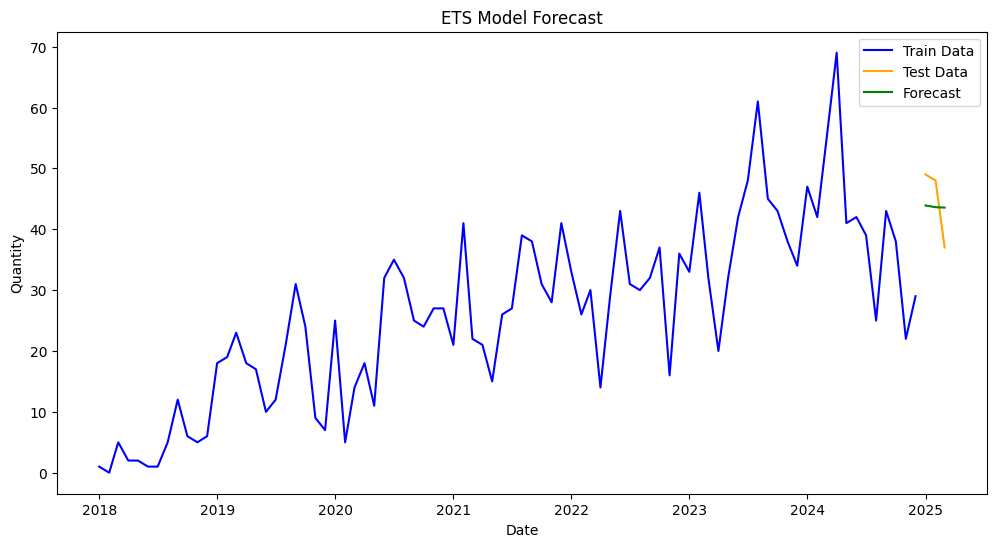

In [19]:
print("Best Model Configuration:")
print("Best Model Parameters:")
print("Alpha:", best_model.alpha)
print("Beta:", best_model.beta)
print("Gamma:", best_model.gamma)
print("Damped Trend:", best_model.damped_trend)
print("Seasonal Periods:", best_model.seasonal_periods)
print("Damping trend", best_model.damping_trend)
print(f"MAPE: {best_mape}")

print("================================================")
print("================================================")
print("================================================")

print("Init Level:", best_model.initial_level)
print("Init Trend:", best_model.initial_trend)
print("Init Seasonal (as list):", best_model.initial_seasonal.tolist())

print("================================================")
print("================================================")
print("================================================")
print(best_model.summary())


print("================================================")
print("================================================")
print("================================================")


# print the fitted values and the forecast
print("Fitted Values:", best_model.fittedvalues.tolist())
print("Forecasted Values:", y_pred)


print("================================================")
# Plot the fitted values and the forecast
plt.figure(figsize=(12, 6))
plt.plot(df_train_one_d.index, df_train_one_d, label="Train Data", color='blue')
plt.plot(df_test_one_d.index, df_test_one_d, label="Test Data", color='orange')
plt.plot(df_test_one_d.index, y_pred, label="Forecast", color='green')
plt.title("ETS Model Forecast")
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()